In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from geopy.geocoders import Nominatim
import re
from IPython.display import display_html
from itertools import chain,cycle

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
darkmode = True
if darkmode:
    jtplot.style(theme='grade3', context='talk', ticks=True, grid=True)
    
# function to display pandas dataframes side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## extract data

In [2]:
df_2020_raw = pd.read_csv(r'data/raw/huie_surveyData_2020.csv')
df_2021_raw = pd.read_csv(r'data/raw/huie_surveyData_2021.csv')

df_2020 = df_2020_raw.copy()
df_2021 = df_2021_raw.copy()

print(f'The 2020 survey has {len(df_2020)} partcipants.')
print(f'The 2021 survey has {len(df_2021)} partcipants.')

The 2020 survey has 961 partcipants.
The 2021 survey has 362 partcipants.


## transform & clean data

In [3]:
REGIONS_2021 = np.array(
            ["Northland/Te Tai Tokerau",
            "Auckland/Tāmakimakaurau", 
            "Waikato",
            "Bay of Plenty/Te MoanaaToi",
            "Gisborne/Te Tai Rāwhiti",
            "Hawke's Bay/Te Mataua Māui",
            "Taranaki",
            "Manawatū-Whanganui",
            "Wellington/Te WhanganuiaTara",
            "Tasman/Te TaioAorere",
            "Nelson/Whakatū",
            "Marlborough/Te Tauihuotewaka",
            "West Coast /Te Tai Poutini",
            "Canterbury/Waitaha",
            "Otago/Ōtākou",
            "Southland/Murihiku",
            "All regions of the North Island/Te IkaaMāui",
            "All regions of the South Island/Te Wai Pounamu",
            "All regions of Aotearoa/New Zealand"]
)

# define function to aggregate data based on the columns
def aggregate_regions(df_in, reg_cols, col_name='location'):
    '''
    Takes raw df as input and outputs df with aggregated 
    regions for each entry in new location column
    '''
    df_out = df_in.copy()
    
    df_out = df_out.replace(np.nan, '', regex=True)                        # replace nans for easier agreggation
    df_out[col_name] = df_out[reg_cols].T.agg(','.join)             # aggregation
    df_out = df_out.replace(',,', '', regex=True)                        # gets rid of double commas
    
    return df_out

# define function to ensure that there's no entry with an empty location
def gis_quality_check(df_in):
    '''
    Checks for empty entries in the location column for input df_in
    '''
    
    print(f'='*60)
    print(f'Carrying out data quality check:')
    print(f'-'*55)
    
    is_loc_empty =  [(lambda s: s == '')(s) for s in df_in['location']]
    n_empty = len(df_in['location'][is_loc_empty])
    
    if n_empty == 0:
        print(f'The data has no empty entries in the location column')
    else:
        print(f'The data has {n_empty} empty entries in the location column.')
        print('Removing empty entries:')
        ind_empty = np.where(is_loc_empty)[0]
        df_in = df_in.drop(ind_empty)
            
    print(f'Data quality completed succesfully.')
    print(f'='*60)
    
    return df_in
    
def remove_comma(df_in, which):
    '''
    Inputs df from aggregate_regions output and removes the 
    '''
    df_out = df_in.copy()

    # track what comma to remove (index) based on which input
    ind = 0 if which == 'first' else -1
    # remove comma with lambda function
    with_comma = [(lambda s: s[ind] == ',')(s) for s in df_in['location']]
    if False:
        with_comma = []
        for s in df_in['location']:
            try: 
                with_comma.append(s[ind] == ',')
            except IndexError:
                print(s)
                with_comma.append(False)

    if which == 'first': 
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[1:])
    elif which == 'last':
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[:-1])

    return df_out


def enrichment_pipeline(df_in, region_cols):
    '''
    Pulls all etl function for cleaning regional data together
    '''
    
    df_out = df_in.copy()
    
    # call region aggregator
    df_out = aggregate_regions(df_out, region_cols)
    
    # call quality data function to check for empty entries
    df_out = gis_quality_check(df_out)
    
    # call function to remove commas 
    df_out = remove_comma(df_out, which='first')
    df_out = remove_comma(df_out, which='last')
    
    return df_out


# define region columns (they change for 2021 and 2020 surveys)
#region_cols_2021 = ['In which region(s) does your organisation operate (please choose all that apply)'] + [f'Unnamed: {j}' for j in range(14,32+1)]
region_cols_2020 = df_2020.keys()[15:32]
region_cols_2021 = df_2021.keys()[13:32]

# run dataframes through enrichment pipeline
df_2020 = enrichment_pipeline(df_2020, region_cols_2020)
df_2021 = enrichment_pipeline(df_2021, region_cols_2021)

# rename regional columns in 2021 
df_2021 = df_2021.rename({old: new for old, new in zip(region_cols_2021,REGIONS_2021)}, axis=1)

Carrying out data quality check:
-------------------------------------------------------
The data has 4 empty entries in the location column.
Removing empty entries:
Data quality completed succesfully.
Carrying out data quality check:
-------------------------------------------------------
The data has 1 empty entries in the location column.
Removing empty entries:
Data quality completed succesfully.


## group data for counting regions

In [60]:
def count_regions(df_in, region_arr, generic_regions, year=2020):
    '''
    Gets enriched dataframes and returns df with 
    partcipation (and percentage of participation) in each regional council 
    '''
    
    df_out = df_in.copy()
    
    if year == 2020:
        split = lambda s: s.split('region: ')[-1]
    elif year == 2021:
        split = lambda s: s.split('/')[0]
        
    count_dict = {split(reg):0 for reg in region_arr if reg not in generic_regions}
                
    df_out['count'] = ''
    grouped_reg = df_out.groupby([reg for reg in region_arr if reg not in generic_regions])['count'].count().reset_index()
    
    # loop through grouped array
    for i, row in grouped_reg.iterrows():
        for region in region_arr:
            if region not in generic_regions and row[region] != '':
                count_dict[split(region)] += row['count']
            elif region == 'All regions of Aotearoa/New Zealand':
                for key in count_dict.keys():
                    count_dict[key] += 1
    # create dataframe with regional counts
    df_regcount = pd.DataFrame(count_dict.items(), columns=['region', 'participation_count'])
    # add partcipation percentage
    df_regcount['participation_perc'] = np.round((df_regcount.participation_count/df_regcount.participation_count.sum())*100, 1)
    
    return df_regcount
            
# define input parameters for each year            
regions_2020 = df_2020.keys()[15:32]
generic_regions_2020 = [
    'region: NZ', 
    'region: NI', 
    'region: SI'
]

regions_2021 = [
    
    "Northland/Te Tai Tokerau",
    "Auckland/Tāmakimakaurau", 
    "Waikato",
    "Bay of Plenty/Te MoanaaToi",
    "Gisborne/Te Tai Rāwhiti",
    "Hawke's Bay/Te Mataua Māui",
    "Taranaki",
    "Manawatū-Whanganui",
    "Wellington/Te WhanganuiaTara",
    "Tasman/Te TaioAorere",
    "Nelson/Whakatū",
    "Marlborough/Te Tauihuotewaka",
    "West Coast /Te Tai Poutini",
    "Canterbury/Waitaha",
    "Otago/Ōtākou",
    "Southland/Murihiku",
    "All regions of the North Island/Te IkaaMāui",
    "All regions of the South Island/Te Wai Pounamu",
    "All regions of Aotearoa/New Zealand"
]

generic_regions_2021 = [
    "All regions of the North Island/Te IkaaMāui",
    "All regions of the South Island/Te Wai Pounamu",
    "All regions of Aotearoa/New Zealand"
    
]

# call function to make df with participation count per region
df_regcount_2020 = count_regions(df_2020, regions_2020, generic_regions_2020, year=2020)
df_regcount_2021 = count_regions(df_2021, regions_2021, generic_regions_2021, year=2021)

# now introduce two rules for df_reg_count_2020: (i) turn Tasman-Nelson-Marlborough into three rows and (ii) include macron in 'Manawatū-Wanganui'
T_N_M = 'Tasman-Nelson-Marlborough'
ind_arr_1 = np.where(df_regcount_2020['region'] == T_N_M)[0]

if len(ind_arr_1) > 0:
    ind_rule_1 = ind_arr_1[0]
    df_regcount_2020.at[ind_rule_1, 'region'] =  T_N_M.split('-')[0]
    pc_tnm, pc_perc_tnm = df_regcount_2020.loc[ind_rule_1].values[1:]
    for i in range(1,3):
        vals = [T_N_M.split('-')[i], pc_tnm, pc_perc_tnm]
        df_i = pd.DataFrame({key: [val] for key,val in zip(df_regcount_2020, vals)})
        df_regcount_2020 = pd.concat([df_regcount_2020, df_i]).reset_index(drop=True)

ind_arr_2 = np.where(df_regcount_2020['region'] == 'Manawatu-Wanganui')[0]
   
if len(ind_arr_2) > 0:
    ind_rule_2 = ind_arr_2[0]
    df_regcount_2020.at[ind_rule_2, 'region'] =  'Manawatū-Whanganui'
    
display_side_by_side(df_regcount_2020, df_regcount_2021)

,region,participation_count,participation_perc
0,Northland,52,5.4
1,Auckland,126,13.1
2,Waikato,66,6.9
3,Bay of Plenty,93,9.7
4,Gisborne,18,1.9
5,Hawke's Bay,30,3.1
6,Taranaki,44,4.6
7,Manawatū-Whanganui,38,4.0
8,Wellington,83,8.6
9,Tasman,27,2.8


## pull gdp per capita data

In [61]:
def extract_gdp(fp="data/processed/gdp-per-capita_2020_regional.csv"):
    '''
    Extracts the gdp per capita for each region (separate csv file)
    and pulls it into a master df. All dataset are publicly available here:
    http://webrear.mbie.govt.nz/theme/gdp-per-capita/map/timeseries/2020/new-zealand?right-transform=absolute
    '''

    df_list = []
    for i, region in enumerate(df_regcount_2021['region']):

        # define filename
        reg_fn = region.lower()
        # need to add all this logic so files are read properly
        if reg_fn == r"bay of plenty":
            reg_fn = r"bay-of-plenty"
        elif reg_fn == r"hawke's bay":
            reg_fn = r"hawkes-bay"
        elif reg_fn == r"manawatū-whanganui":
            reg_fn = "manawatu-wanganui"
        elif reg_fn == r"west coast":
            reg_fn = "west-coast"
        # extract data
        filename = f"gdp-per-capita-annual-mar-{reg_fn}--annual-rate.csv"
        df_i = pd.read_csv(f"data/gis/gdp/"+filename)
        
        # transform df  
        df_i = df_i[df_i['Year'] == 2020]                                                       # only take the GDP for the most recent year available (2020)
        df_i['region'] = region                                                                 # add column with region
        df_i = df_i[['region', 'The GDP per capita']]                                           # get rid of redundant columns
        df_i = df_i.rename(columns={'The GDP per capita': 'gdp_pc'})                            # rename column for easier processing (GDP is in NZD)
        df_i['gdp_pc'] = df_i['gdp_pc'].replace(',', '', regex=True).astype(np.int32)           # transform gdp from str to int (need to get rid of commas first) 
    
                         
        df_list.append(df_i)
    
    # concatenate dataframe and save it
    df_gdp = pd.concat(df_list, ignore_index=True)
    df_gdp.to_csv(fp, index=False)

    
# extract gdp per capita and load into dataframe
filepath_gdp = "data/processed/gdp-per-capita_2020_regional.csv"
try:
    df_gdp = pd.read_csv(filepath_gdp)
except FileNotFoundError:
    extract_gdp(fp=filepath_gdp)
    
# create column of gdp_pc percentage
df_gdp['gdp_pc_perc'] = np.round((df_gdp.gdp_pc/df_gdp.gdp_pc.sum())*100, 1)

display_side_by_side(df_regcount_2020, df_regcount_2021, df_gdp)

,region,participation_count,participation_perc
0,Northland,52,5.4
1,Auckland,126,13.1
2,Waikato,66,6.9
3,Bay of Plenty,93,9.7
4,Gisborne,18,1.9
5,Hawke's Bay,30,3.1
6,Taranaki,44,4.6
7,Manawatū-Whanganui,38,4.0
8,Wellington,83,8.6
9,Tasman,27,2.8


## gis analysis (with NZ map)

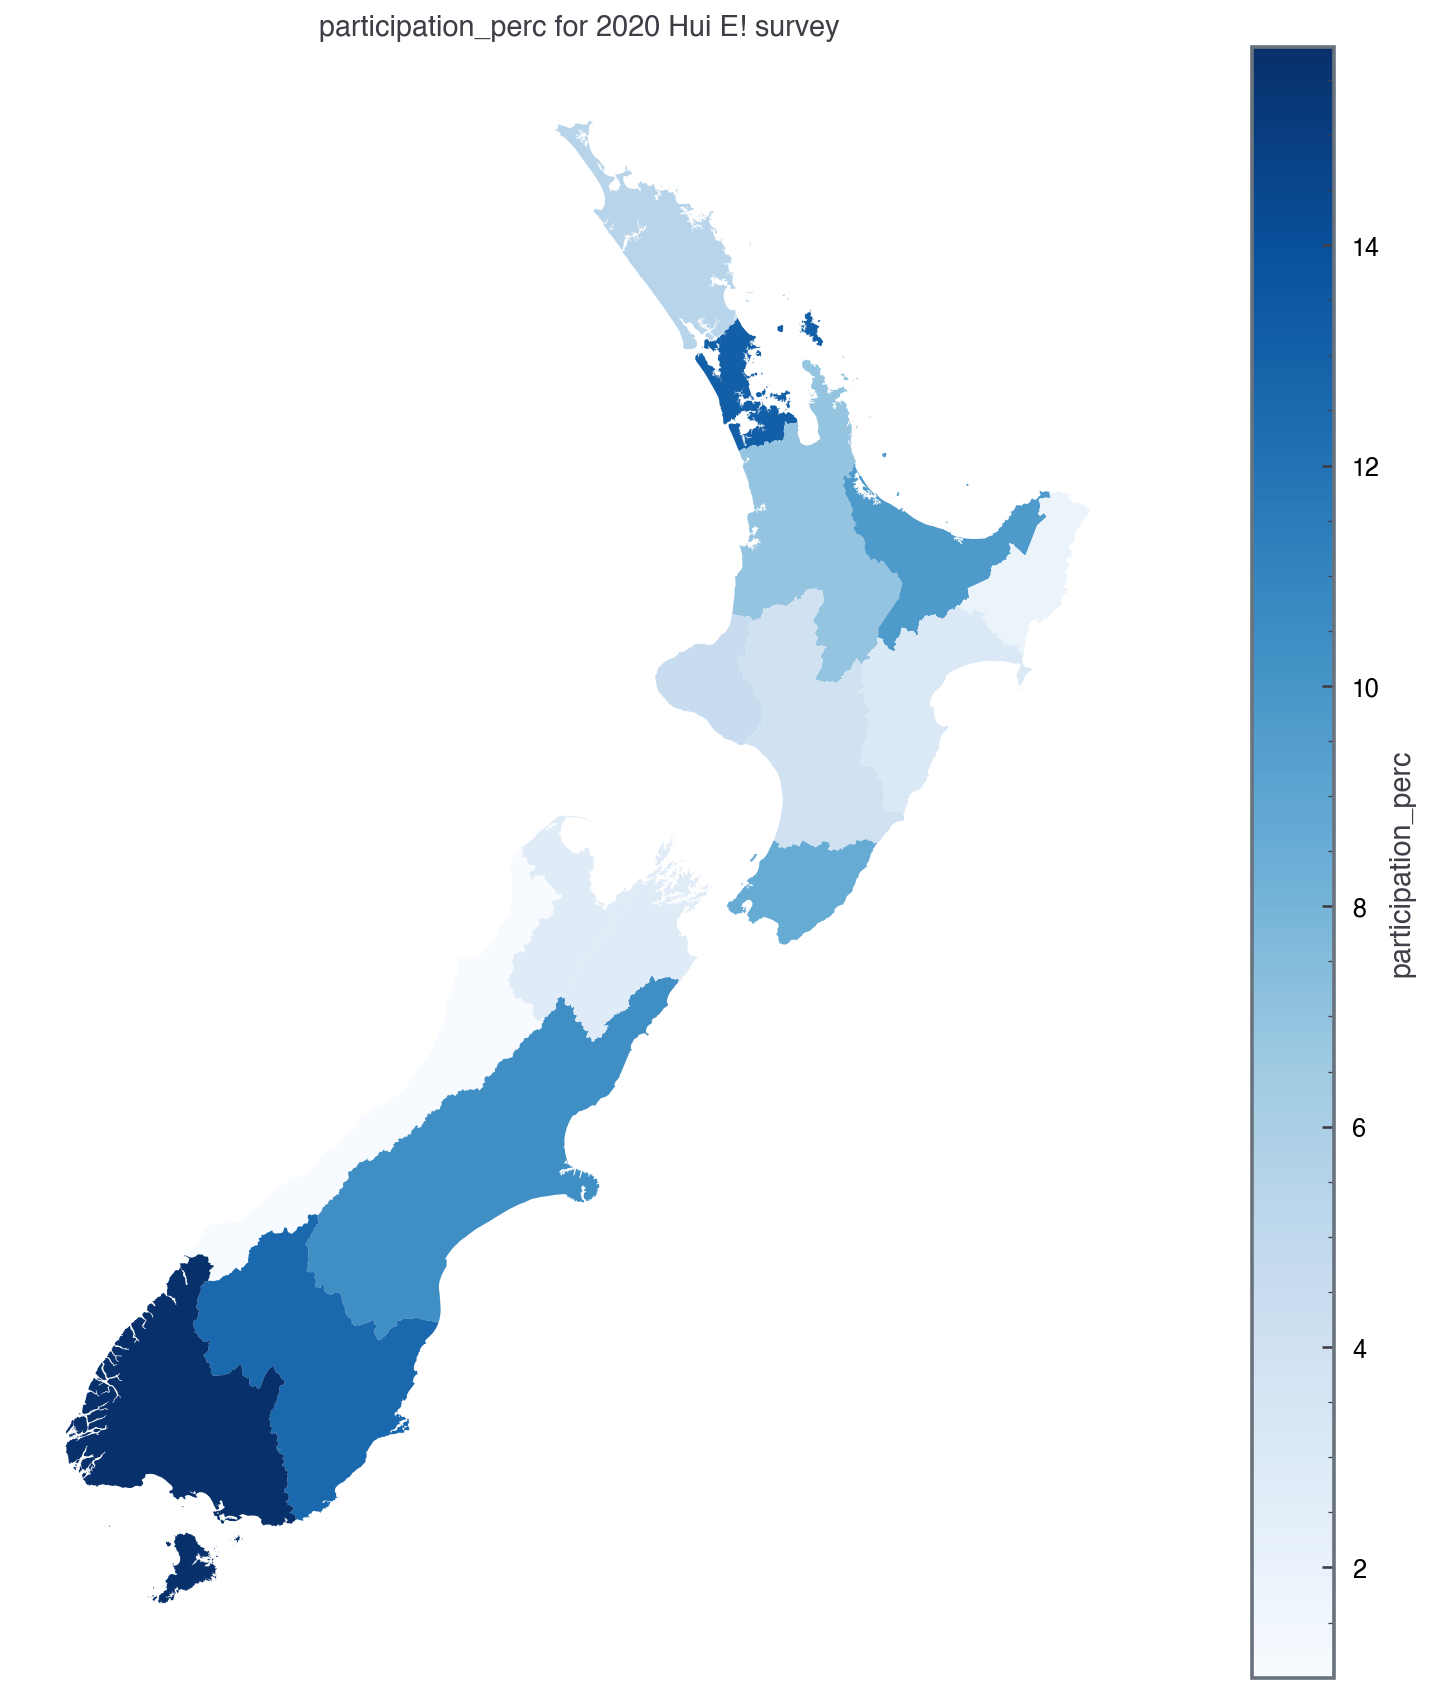

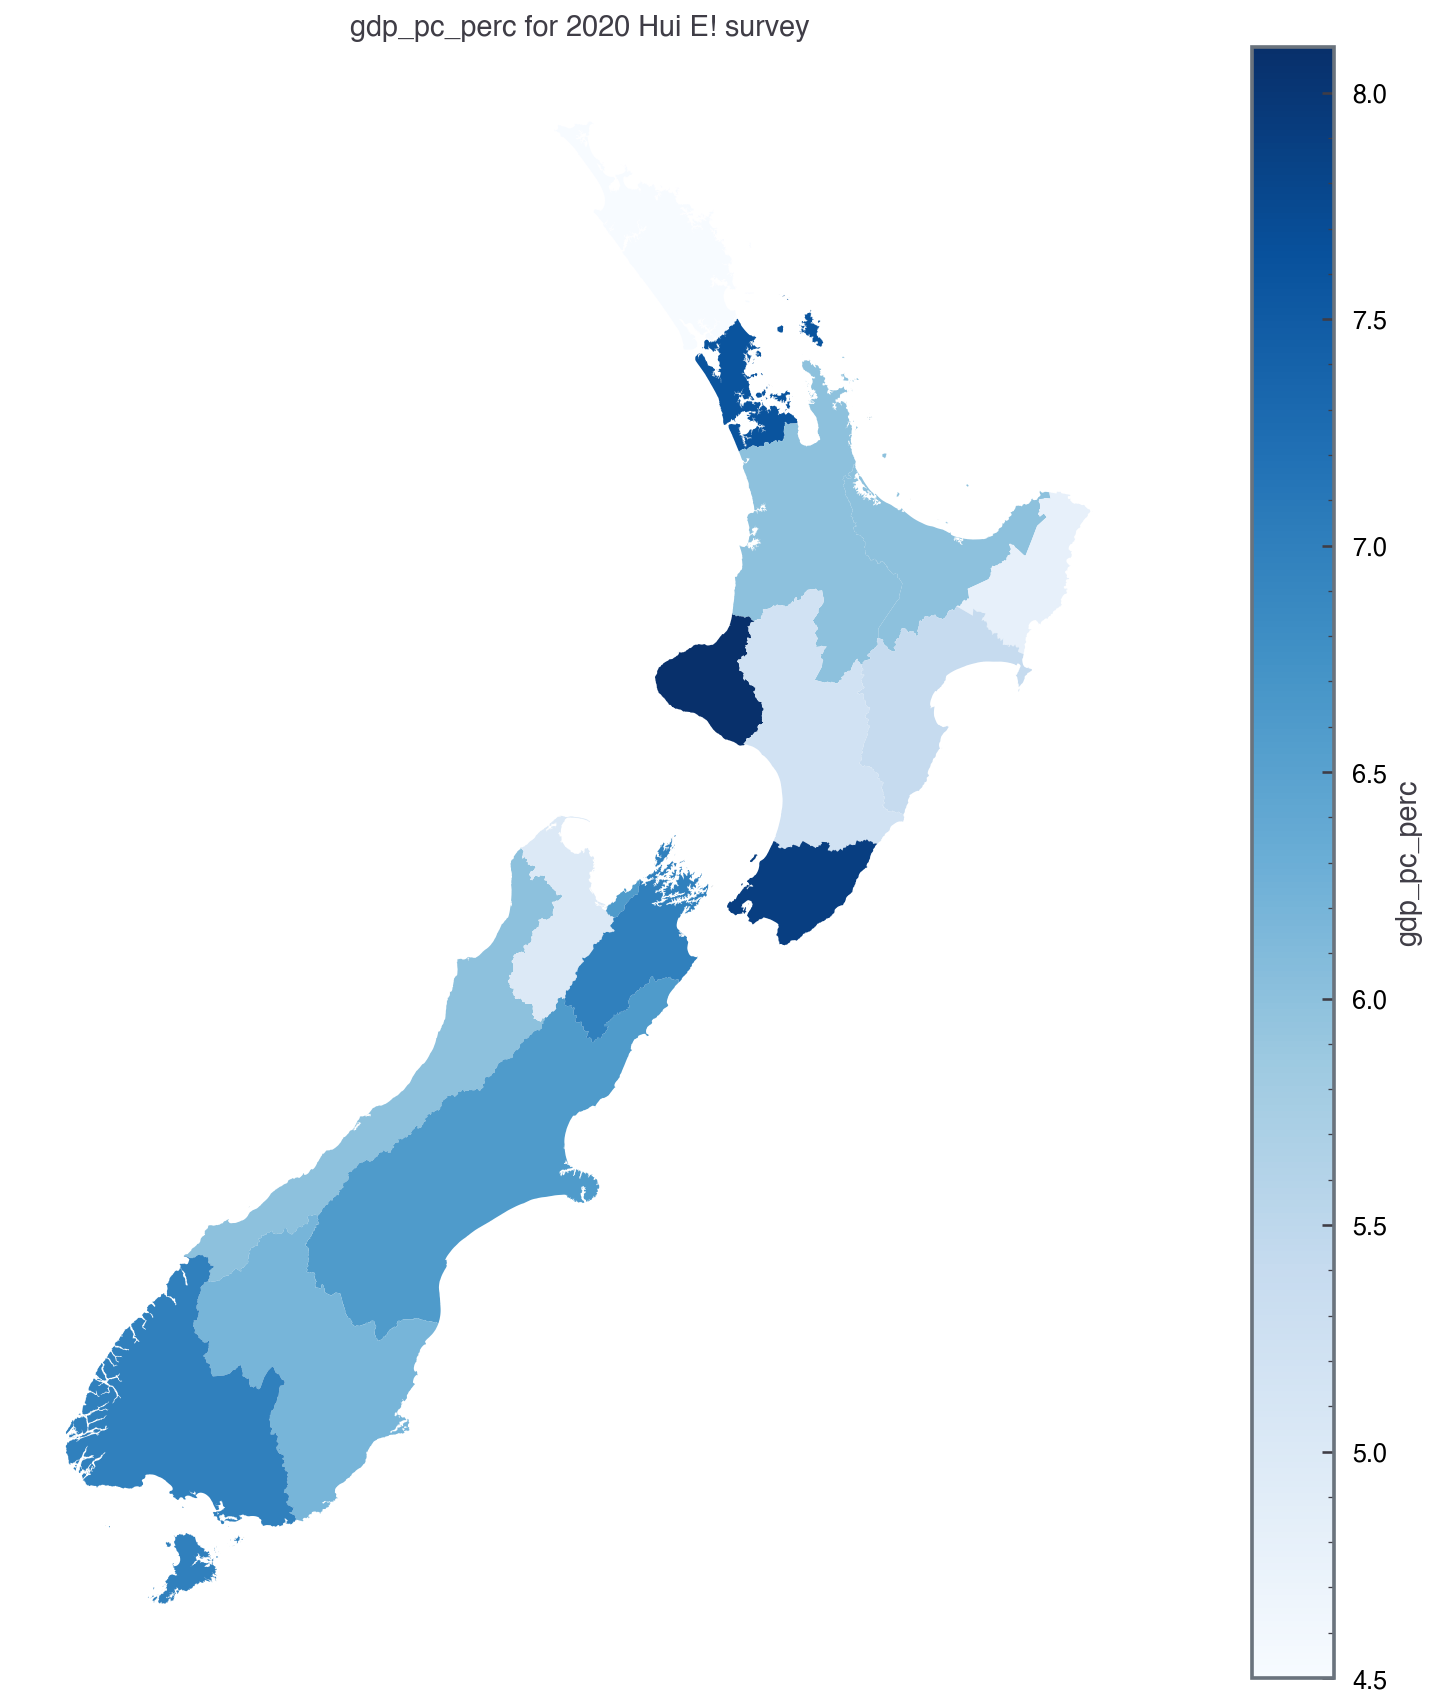

In [66]:
import geopandas as gpd

def extract_geodataframe(csv_fp, shp_fp):
    '''
    Reads the csv and shp files from NZ's regional councils and
    creates a geodataframe to plot the map of NZ. Files publicily available here:
    https://datafinder.stats.govt.nz/layer/106667-regional-council-2022-clipped-generalised/
    '''
    gdf_shp = gpd.read_file(csv_fp)
    gdf_csv = gpd.read_file(shp_fp)

    # get rid of redundand columns and of extra region wording
    gdf_csv = gdf_csv[["REGC2022_V1_00_NAME"]]
    gdf_csv = gdf_csv.replace(' Region', '', regex=True)  
    gdf_csv = gdf_csv.rename(columns={'REGC2022_V1_00_NAME': 'region'})
    # join two dataframes and get rid of Outside NZ region
    gdf_map = gdf_csv.merge(gdf_shp, left_index=True, right_index=True)
    gdf_map = gdf_map.drop(gdf_map.index[-1], axis=0)
    gdf_map = gpd.GeoDataFrame(gdf_map)
    
    return gdf_map

#def data2gdf(gdf):

# define function to draw NZ map
def draw_map(gdf, col_count=None):
    '''
    Draws map of input dataframe (assume multipolygon) geometry
    '''
    
    fig, ax = plt.subplots(figsize=(24,15))
    
    if col_count is None:
        gdf.plot(ax=ax)
    else:
        gdf.plot(
            ax=ax, 
            column=col_count, 
            legend=True,
            cmap="Blues",
            legend_kwds={'label': col_count}
                )
        plt.title(f"{col_count} for 2020 Hui E! survey")
        plt.subplots_adjust(right=0.75)
    
    plt.axis("off")
    plt.show()
    
def metrics2map(df_regcount, gdp_df, gdf_gismap):
    '''
    Merges the metrics, with the gdp per capita and the map
    '''
        
    # merge geodataframe and counting df
    df_gis = df_regcount.merge(gdp_df, left_on='region', right_on='region') 

    gdf_metrics = gdf_gismap.merge(df_gis, left_on='region', right_on='region') 
    gdf_metrics = gpd.GeoDataFrame(gdf_metrics)
    
    return gdf_metrics

# call function to extract geodataframe of NZ's regional councils
csv_filepath = "data/gis/regional-council-2022-clipped-generalised.shx"
shp_filepath = "data/gis/regional_council_2022_clipped_csv.csv"
gdf_map = extract_geodataframe(csv_filepath, shp_filepath)

# call function to get map_metrics
gdf_metrics_2020 = metrics2map(df_regcount_2020, df_gdp, gdf_map)
gdf_metrics_2021 = metrics2map(df_regcount_2021, df_gdp, gdf_map)

#df_metrics

# call map drawing function
#draw_map(gdf_new, col_count='participation_count')
draw_map(gdf_metrics_2020, col_count='participation_perc')
#draw_map(gdf_new, col_count='gdp_pc')
draw_map(gdf_metrics_2020, col_count='gdp_pc_perc')

## create specifically customized plots

NameError: name 'gdf_new' is not defined

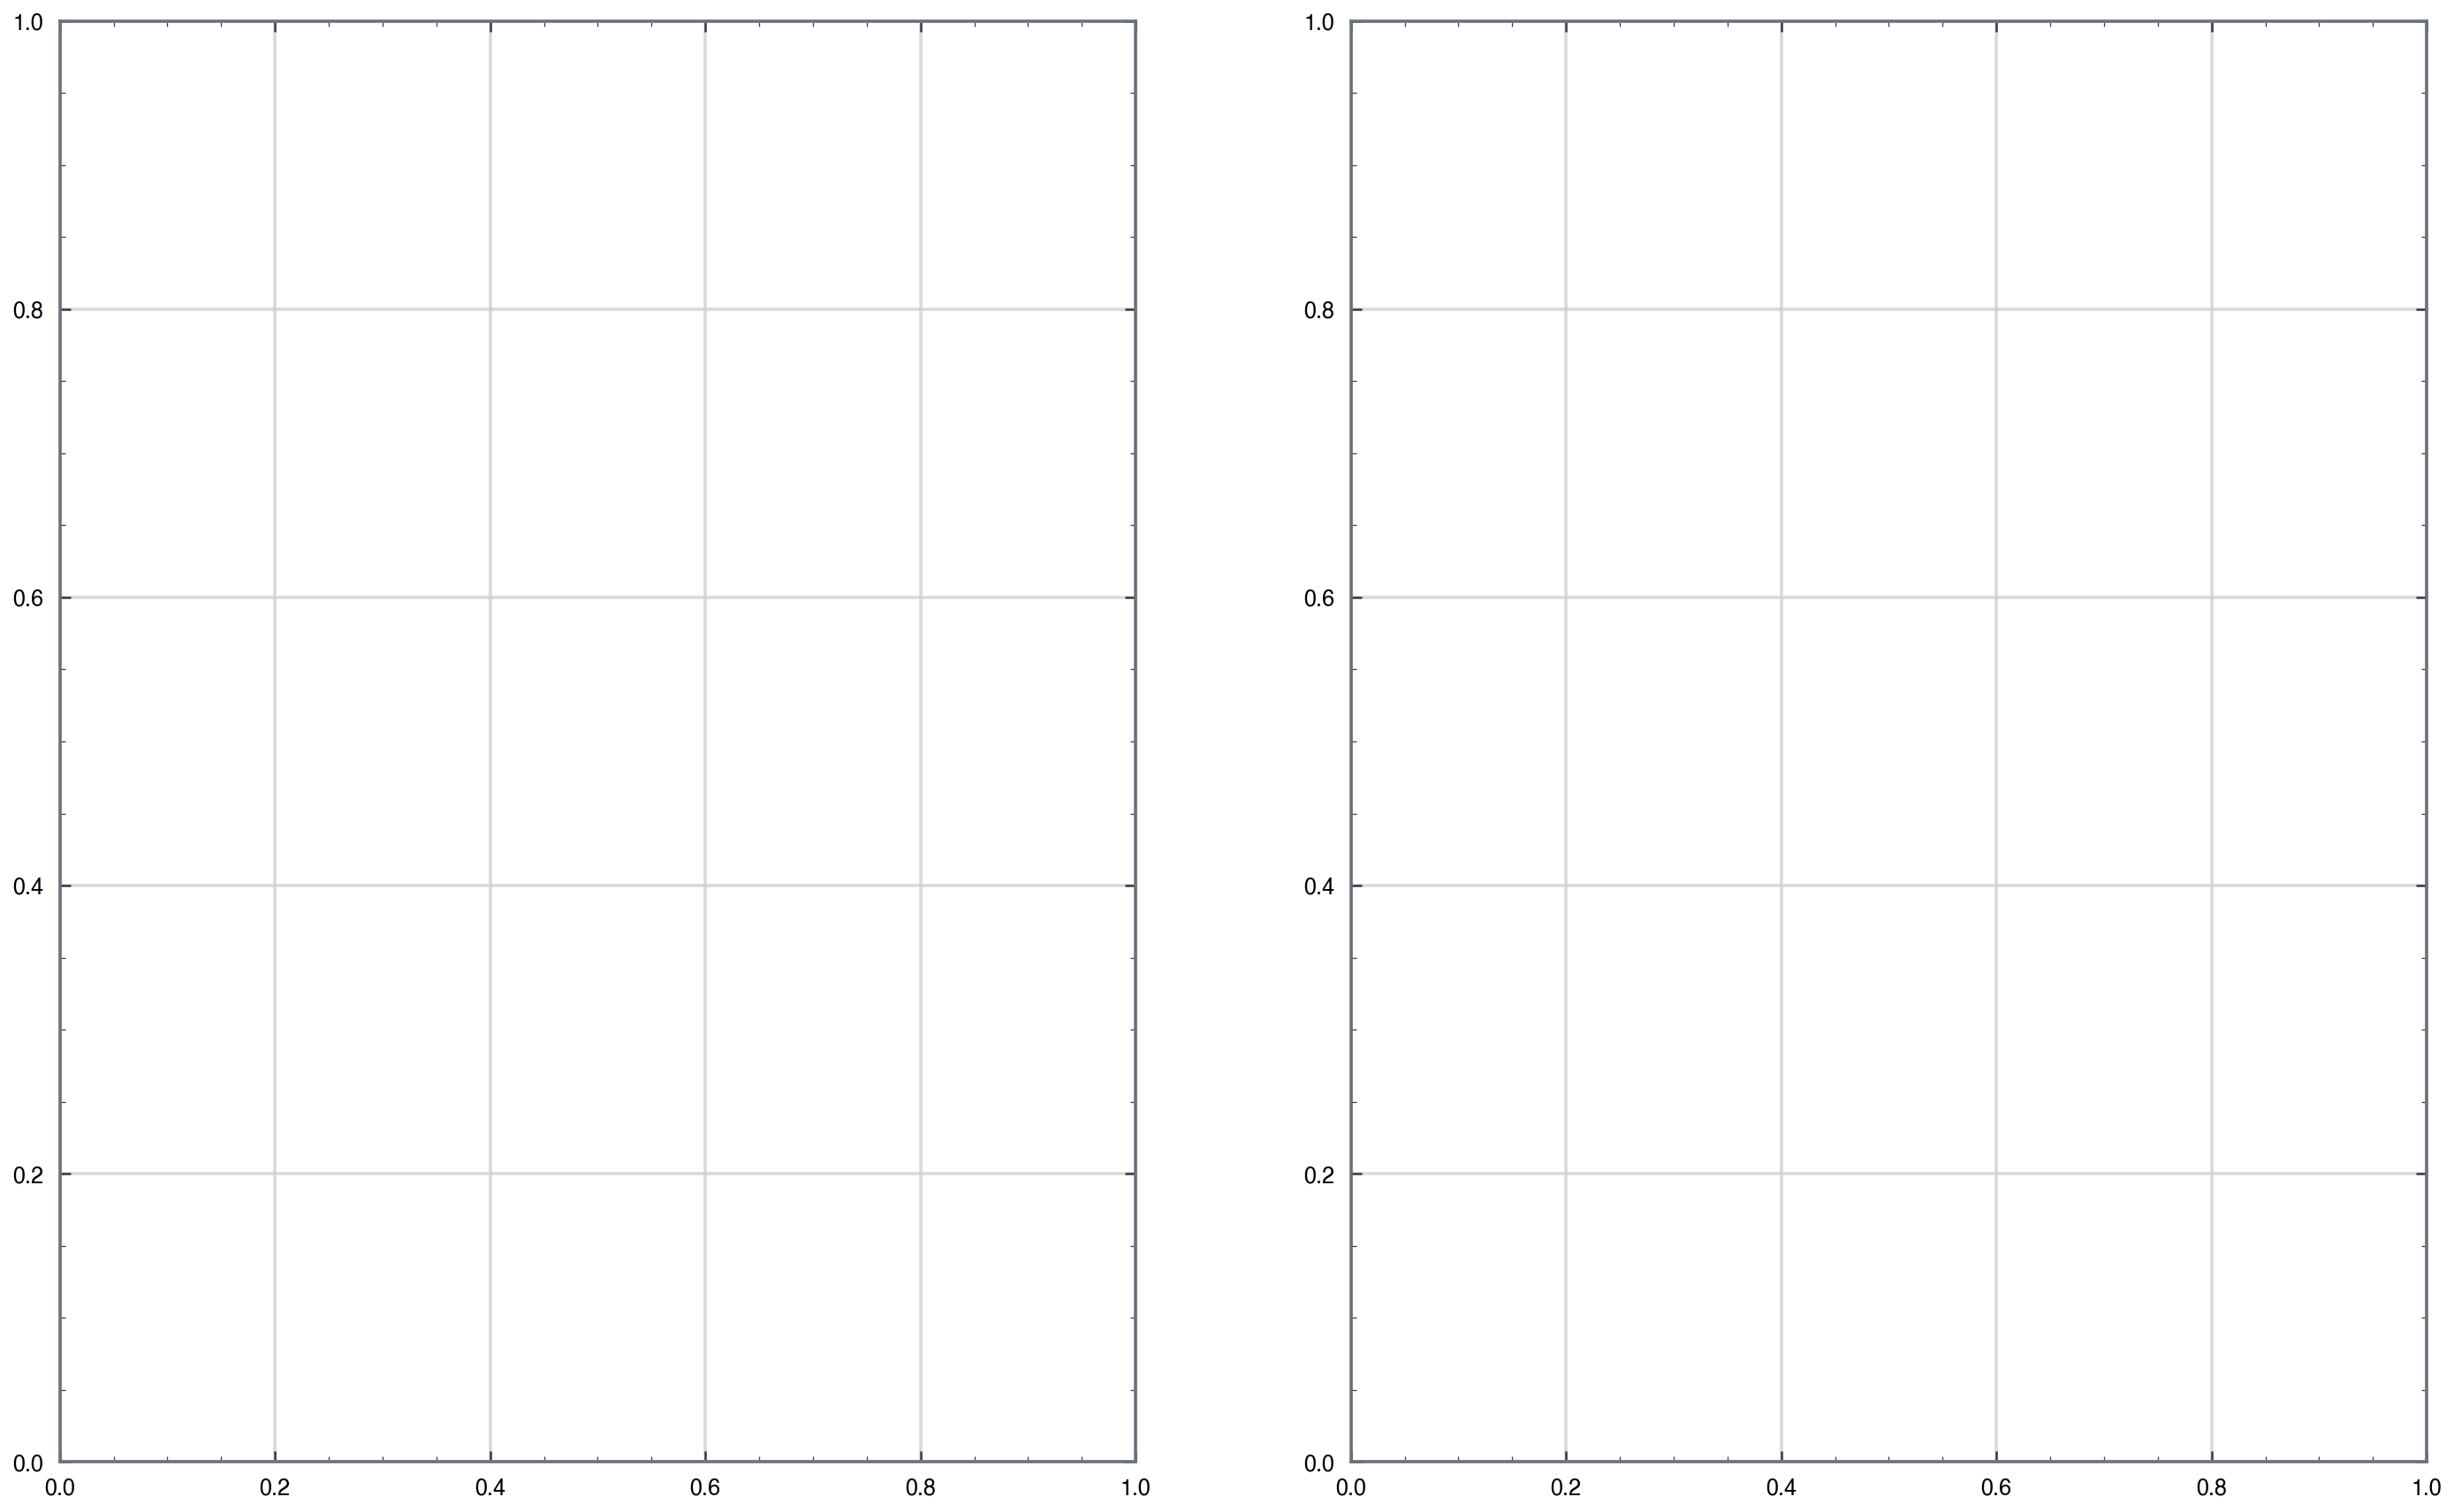

In [68]:
fig, axs = plt.subplots(1,2, figsize=(24,15))

# plot the two maps for 
gdf_new.plot(
    column='participation_perc', 
    ax=axs[0], 
    legend=True,
    cmap="Blues",
    legend_kwds={'label': 'percentage (%)'}
)
axs[0].set_title(f"Participation percentange in Hui E!'s 2020 survey", fontsize=25)

gdf_new.plot(
    column='gdp_pc_perc', 
    ax=axs[1], 
    legend=True,
    cmap="Blues",
    legend_kwds={'label': 'percentage (%)'}

)
axs[1].set_title(f"Contribution of GDP per capita in Aotearoa/New Zealand", fontsize=25)

for i in range(2):
    axs[i].axis("off")

plt.tight_layout()
save_fig = False
if save_fig:
    title = r'assets/2020 graphs/gis_analysis_-_participation_vs_gdp.png'
    try:
        plt.savefig(title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight', facecolor='w')
    except FileNotFoundError:
        os.mkdir(r'assets/2020 graphs')
        plt.savefig(title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight', facecolor='w')
plt.show()

## questions for quotes 

In [ ]:
text = 'The COVID-19 pandemic has had multiple structural/operational/financial impacts upon our tangata whenua, community and voluntary organisations in Aotearoa/New Zealand. That considered, the pandemic may have also had impacts on the wellbeing and emotional/morale status and stress levels of people in these organisations. Can you tell us a short story about your experiences?'

if True:
    print(df_2021[text].values)